In [74]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc

In [75]:
SCORES_DIR = "./eval/scores"
ECAPA_DIR = SCORES_DIR + "/ecapa"
ECAPA_SCHED_DIR = SCORES_DIR + "/ecapa-scheduler"

In [76]:
def load_scores(file_path):
    print(f"Loading scores from {file_path}")
    return pd.read_csv(file_path, sep=' ', names=['label', 'score'])
    
# def calculate_eer(y, y_score):
#     fpr, tpr, thresholds = roc_curve(y, y_score)
#     eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
#     return eer

def calculate_eer(y, y_scores):
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    # Use interpolation? for higher precision
    EER = (fpr[idx] + fnr[idx]) / 2  
    return EER


def calculate_minDCF(y, y_scores, p_target=0.01, c_miss=1, c_fa=1):
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    fnr = 1 - tpr
    dcf = p_target * c_miss * fnr + (1 - p_target) * c_fa * fpr
    min_dcf = min(dcf)
    return min_dcf

In [77]:
def plot_metrics(epochs, metrics, title, ylabel):
    plt.figure()
    plt.plot(epochs, metrics, marker='o')
    plt.xlabel('Epoch')
    # Set x-axis values to be integers, values from epochs list
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
   
def process_model_scores(model, model_path, epochs):
    eers = []
    mindcfs = []
    for epoch in epochs:
        file_path = f"{model_path}/{model}.{epoch}.scores"
        df = load_scores(file_path)
        eer = calculate_eer(df['label'], df['score'])
        min_dcf = calculate_minDCF(df['label'], df['score'])
        eers.append(eer)
        mindcfs.append(min_dcf)
    return eers, mindcfs

In [91]:
# ECAPA
epochs = [5, 10, 15, 20, 25, 30]
ecapa_eers, ecapa_mindcfs = process_model_scores('ecapa', ECAPA_DIR, epochs)

# ECAPA w/ scheduler
sch_epochs = [5, 10, 15, 20]
ecapa_sch_eers, ecapa_sch_mindcfs = process_model_scores('ecapa-scheduler', ECAPA_SCHED_DIR, sch_epochs)


Loading scores from ./eval/scores/ecapa/ecapa.5.scores
Loading scores from ./eval/scores/ecapa/ecapa.10.scores
Loading scores from ./eval/scores/ecapa/ecapa.15.scores
Loading scores from ./eval/scores/ecapa/ecapa.20.scores
Loading scores from ./eval/scores/ecapa/ecapa.25.scores
Loading scores from ./eval/scores/ecapa/ecapa.30.scores
Loading scores from ./eval/scores/ecapa-scheduler/ecapa-scheduler.5.scores
Loading scores from ./eval/scores/ecapa-scheduler/ecapa-scheduler.10.scores
Loading scores from ./eval/scores/ecapa-scheduler/ecapa-scheduler.15.scores
Loading scores from ./eval/scores/ecapa-scheduler/ecapa-scheduler.20.scores


In [92]:
# Print EERs and minDCF values
print("ECAPA EERs:", ecapa_eers)
print("ECAPA minDCFs:", ecapa_mindcfs)

print("ECAPA w/ scheduler EERs:", ecapa_sch_eers)
print("ECAPA w/ scheduler minDCFs:", ecapa_sch_mindcfs)

ECAPA EERs: [0.06349416755037118, 0.07094379639448567, 0.06553552492046658, 0.06391834570519617, 0.06672852598091197, 0.060843054082714745]
ECAPA minDCFs: [0.004791092258748674, 0.005277836691410392, 0.005157476139978792, 0.005339342523860022, 0.0059623541887592795, 0.004843584305408271]
ECAPA w/ scheduler EERs: [0.09066808059384943, 0.0951749734888653, 0.09713679745493109, 0.09756097560975609]
ECAPA w/ scheduler minDCFs: [0.006918875927889714, 0.006752916224814422, 0.0067916224814422044, 0.006834040296924708]


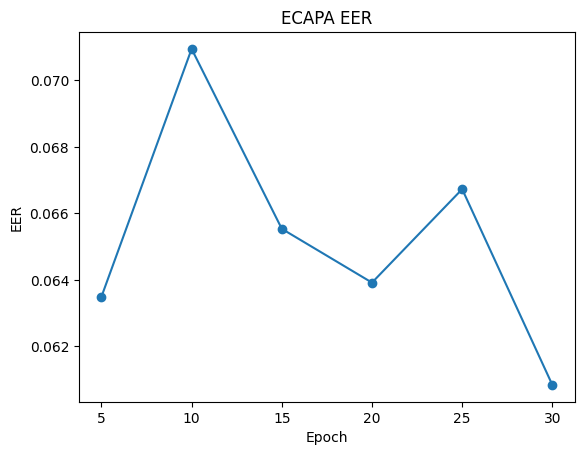

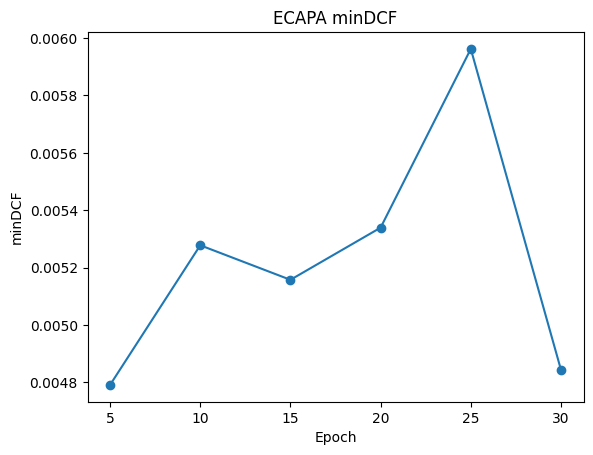

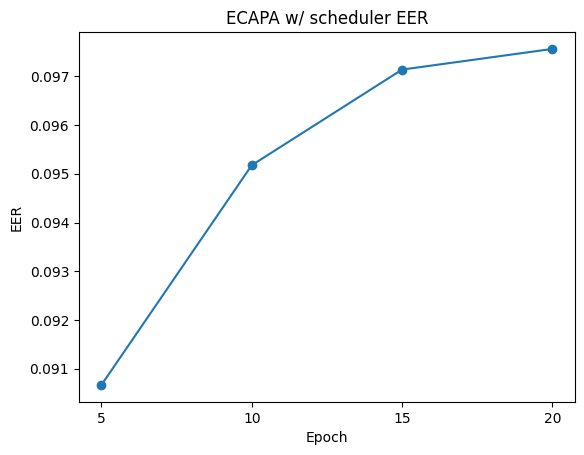

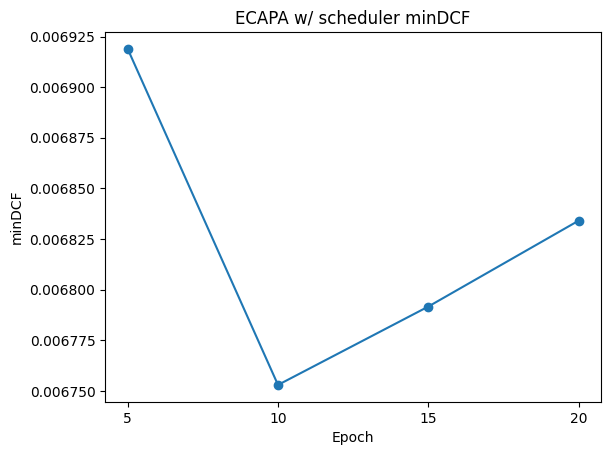

In [93]:
# Plot EERs and minDCF values
plot_metrics(epochs, ecapa_eers, 'ECAPA EER', 'EER')
plot_metrics(epochs, ecapa_mindcfs, 'ECAPA minDCF', 'minDCF')

plot_metrics(sch_epochs, ecapa_sch_eers, 'ECAPA w/ scheduler EER', 'EER')
plot_metrics(sch_epochs, ecapa_sch_mindcfs, 'ECAPA w/ scheduler minDCF', 'minDCF')

In [94]:
def plot_combined_metrics(epochs_ecapa, ecapa_eers, ecapa_mindcfs, epochs_scheduler, scheduler_eers, scheduler_mindcfs):
    """Plot EER and minDCF metrics in subplots for both models with variable epoch data."""
    # Create a figure and a 1x2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) 

    # Plotting EERs (1st subplot)
    ax1.plot(epochs_ecapa, ecapa_eers, marker='o', color='blue', label='ECAPA')
    if epochs_scheduler:  # Check if scheduler data is available
        ax1.plot(epochs_scheduler, scheduler_eers, marker='o', color='green', label='ECAPA-Scheduler')
    ax1.set_title('EER Trends')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('EER')
    ax1.legend()
    ax1.grid(True, alpha=0.5)

    all_epochs = sorted(set(epochs_ecapa + epochs_scheduler))
    ax1.set_xticks(np.arange(min(all_epochs), max(all_epochs) + 1, 5))

    # Plotting minDCFs (2nd subplot)
    ax2.plot(epochs_ecapa, ecapa_mindcfs, marker='o', color='blue', label='ECAPA')
    if epochs_scheduler:  # Check if scheduler data is available
        ax2.plot(epochs_scheduler, scheduler_mindcfs, marker='o', color='green', label='ECAPA-Scheduler')
    ax2.set_title('minDCF Trends')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('minDCF')
    ax2.legend()
    ax2.grid(True, alpha=0.5)
    ax2.set_xticks(np.arange(min(all_epochs), max(all_epochs) + 1, 5))

    plt.tight_layout()
    plt.show()

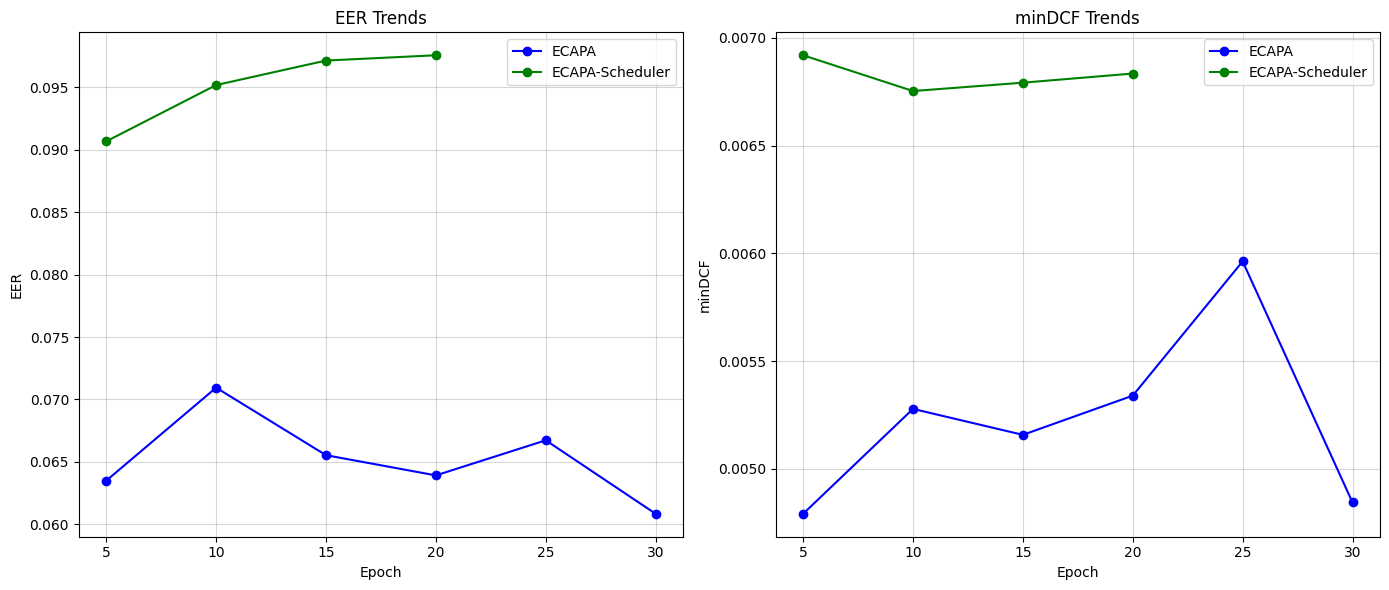

In [95]:
plot_combined_metrics(epochs, ecapa_eers, ecapa_mindcfs, sch_epochs, ecapa_sch_eers, ecapa_sch_mindcfs)

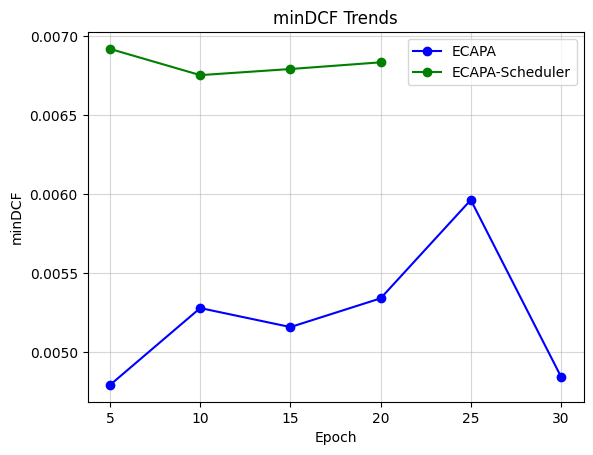

In [96]:
# Plot only minDCF values - ecapa and ecapa-scheduler
plt.figure()
plt.plot(epochs, ecapa_mindcfs, marker='o', color='blue', label='ECAPA')
plt.plot(sch_epochs, ecapa_sch_mindcfs, marker='o', color='green', label='ECAPA-Scheduler')
plt.xlabel('Epoch')
plt.ylabel('minDCF')
plt.title('minDCF Trends')
plt.legend()
plt.grid(True, alpha=0.5)
all_epochs = sorted(set(epochs + sch_epochs))
plt.xticks(np.arange(min(all_epochs), max(all_epochs) + 1, 5))
plt.show()